C:\Users\ozgur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Sistem belirtilen dosyayı bulamıyor
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ozgur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

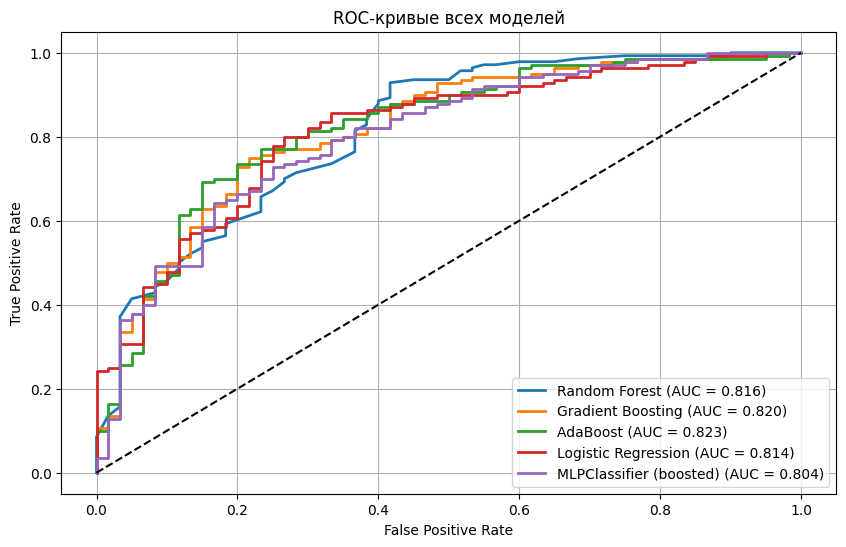

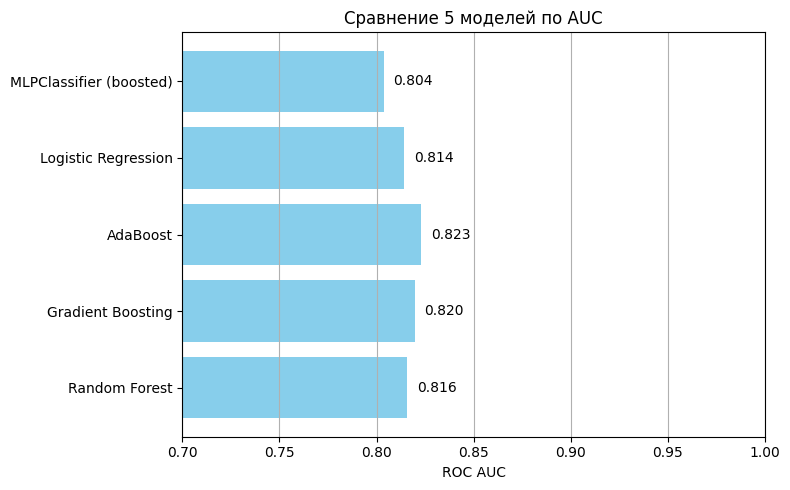


Итоговые значения ROC AUC:
Random Forest: 0.8158
Gradient Boosting: 0.8198
AdaBoost: 0.8231
Logistic Regression: 0.8144
MLPClassifier (boosted): 0.8038


In [1]:

# !pip install imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

df = pd.read_csv("german.csv", sep=";")
X = df.drop("Creditability", axis=1)
y = df["Creditability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
    "MLPClassifier (boosted)": MLPClassifier(
        hidden_layer_sizes=(512, 256, 128, 64),
        activation='relu',
        learning_rate_init=0.002,
        alpha=1e-5,
        solver='adam',
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=42
    )
}

plt.figure(figsize=(10, 6))
auc_scores = {}
for name, model in models.items():
    if "MLP" in name:
        model.fit(X_train_resampled, y_train_resampled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    score = roc_auc_score(y_test, y_proba)
    auc_scores[name] = score
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые всех моделей")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.barh(list(auc_scores.keys()), list(auc_scores.values()), color='skyblue')
plt.xlabel("ROC AUC")
plt.title("Сравнение 5 моделей по AUC")
for i, (model, score) in enumerate(auc_scores.items()):
    plt.text(score + 0.005, i, f"{score:.3f}", va='center')
plt.xlim(0.7, 1.0)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

print("\nИтоговые значения ROC AUC:")
for model, score in auc_scores.items():
    print(f"{model}: {score:.4f}")
